## Support-Resistance Breakout Strategy

原則:  
- 選擇股價波動大且成交量大的標的  
- 定義 ```breakout rule```  
- 定義 ```exit/stop loss signal```  
- 用 cumulative return 計算每個標的的 returnm

策略:  
- ```breakout rule```: 20 period rolling max/min + 20 days rolling volume  
- ```exit/stop loss```: previous price +- 20 period ATR

### 1. 引入套件:

In [169]:
import tejapi

In [170]:
tejapi.ApiConfig.api_key = "09vOL7Mk5yamPfvzSffVkl6iKb0fHJ"

In [171]:
info = tejapi.ApiConfig.info()

In [172]:
data = tejapi.get('TRAIL/TAGIN')

In [173]:
data

,coid,mdate,gin0,l0ng_ta,buy_l,buy_la,sell_l,sell_la,cash_l,cash_la,...,limit_b1,limit_b2,sbls_k,shorts_k,ap,alc,asc1,lmr,smr,tmr
None,,,,,,,,,,,,,,,,,,,,,
0,0050,2020-01-02 00:00:00+00:00,374,36513.62,20,1952.60,6,585.78,0,0.0,...,1006,68700,31990.95,195.4,97.6300,95.93,87.11,169.65,169.49,169.58
1,0050,2020-01-03 00:00:00+00:00,388,37907.60,30,2931.00,16,1563.20,0,0.0,...,1041,66950,21216.45,195.7,97.7000,96.07,87.23,169.41,169.73,169.55
2,0050,2020-01-06 00:00:00+00:00,381,36827.46,7,676.62,14,1353.24,0,0.0,...,1120,66950,33959.20,386.5,96.6600,96.08,87.45,167.23,172.36,169.44
3,0050,2020-01-07 00:00:00+00:00,410,39351.80,41,3935.18,12,1151.76,0,0.0,...,1158,66950,49379.95,287.6,95.9800,96.07,87.61,166.72,173.21,169.32
4,0050,2020-01-08 00:00:00+00:00,441,42133.14,51,4872.54,20,1910.80,0,0.0,...,1205,66050,53815.30,477.8,95.5400,96.01,87.84,166.05,174.49,169.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,00657,2020-10-23 00:00:00+00:00,0,0.00,0,0.00,0,0.00,0,0.0,...,32,432,0.00,0.0,29.2496,NaN,NaN,NaN,NaN,NaN
9996,00657,2020-10-26 00:00:00+00:00,0,0.00,0,0.00,0,0.00,0,0.0,...,32,432,0.00,0.0,29.1601,NaN,NaN,NaN,NaN,NaN
9997,00657,2020-10-27 00:00:00+00:00,0,0.00,0,0.00,0,0.00,0,0.0,...,32,432,0.00,0.0,29.0498,NaN,NaN,NaN,NaN,NaN


In [174]:
import numpy as np
import pandas as pd
import copy
import time

In [175]:
from alpha_vantage.timeseries import TimeSeries

In [176]:
def ATR(DF, n):
    df = DF.copy()
    df["H-L"] = abs(df["High"] - df["Low"]) 
    df["H-PC"] = abs(df["High"] - df["Close"].shift(1)) # 今天跳空上漲的情況
    df["L-PC"] = abs(df["Low"] - df["Close"].shift(1)) # 今天跳空下跌
    # 取三者裡的最大者，且不忽略 NaN
    df["TR"] = df[ ["H-L", "H-PC", "L-PC"] ].max(axis=1, skipna=False)
    df["ATR"] = df["TR"].rolling(n).mean() # rolling 的天數自訂，通常用 20
    # 刪除暫時的 columns
    df = df.drop( ["H-L", "H-PC", "L-PC"], axis=1)
    return df["ATR"]

### 2.1. 選擇交易標的:

先用一個股票拆解，之後再用迴圈取得多個股票:

In [177]:
key_path = r"C:\\Users\User\\Quant_Trading\\alpha_vantage\\api_key.txt"
ts = TimeSeries(key=open(key_path, 'r').read(), output_format='pandas')

In [178]:
data = ts.get_intraday(symbol='MSFT', interval='5min', outputsize='full')

In [179]:
type(data) # return tuple object

tuple

In [180]:
data

(                     1. open  2. high    3. low  4. close  5. volume
 date                                                                
 2021-01-29 20:00:00   231.79   231.80  231.6400  231.8000     4474.0
 2021-01-29 19:55:00   231.70   231.70  231.7000  231.7000      496.0
 2021-01-29 19:50:00   231.77   231.77  231.7000  231.7000     2898.0
 2021-01-29 19:45:00   231.84   231.84  231.8199  231.8199      689.0
 2021-01-29 19:40:00   231.63   231.89  231.6300  231.8900      633.0
 ...                      ...      ...       ...       ...        ...
 2021-01-04 04:30:00   223.36   223.39  223.3600  223.3900     1063.0
 2021-01-04 04:25:00   223.04   223.04  223.0400  223.0400      272.0
 2021-01-04 04:20:00   223.40   223.40  223.4000  223.4000      476.0
 2021-01-04 04:15:00   223.39   223.40  223.3900  223.4000      752.0
 2021-01-04 04:05:00   222.75   223.40  222.7500  223.4000     1281.0
 
 [3334 rows x 5 columns],
 {'1. Information': 'Intraday (5min) open, high, low, close pr

In [181]:
data[0] # 這裡的資料由最新到最就是由上往下，應該把它倒過來

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2021-01-29 20:00:00,231.79,231.80,231.6400,231.8000,4474.0
2021-01-29 19:55:00,231.70,231.70,231.7000,231.7000,496.0
2021-01-29 19:50:00,231.77,231.77,231.7000,231.7000,2898.0
2021-01-29 19:45:00,231.84,231.84,231.8199,231.8199,689.0
2021-01-29 19:40:00,231.63,231.89,231.6300,231.8900,633.0
...,...,...,...,...,...
2021-01-04 04:30:00,223.36,223.39,223.3600,223.3900,1063.0
2021-01-04 04:25:00,223.04,223.04,223.0400,223.0400,272.0
2021-01-04 04:20:00,223.40,223.40,223.4000,223.4000,476.0


In [182]:
type(data[0]) # we only need this data frame

pandas.core.frame.DataFrame

In [183]:
data[0].iloc[::-1] # change the order of the dates

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2021-01-04 04:05:00,222.75,223.40,222.7500,223.4000,1281.0
2021-01-04 04:15:00,223.39,223.40,223.3900,223.4000,752.0
2021-01-04 04:20:00,223.40,223.40,223.4000,223.4000,476.0
2021-01-04 04:25:00,223.04,223.04,223.0400,223.0400,272.0
2021-01-04 04:30:00,223.36,223.39,223.3600,223.3900,1063.0
...,...,...,...,...,...
2021-01-29 19:40:00,231.63,231.89,231.6300,231.8900,633.0
2021-01-29 19:45:00,231.84,231.84,231.8199,231.8199,689.0
2021-01-29 19:50:00,231.77,231.77,231.7000,231.7000,2898.0


In [184]:
data

(                     1. open  2. high    3. low  4. close  5. volume
 date                                                                
 2021-01-29 20:00:00   231.79   231.80  231.6400  231.8000     4474.0
 2021-01-29 19:55:00   231.70   231.70  231.7000  231.7000      496.0
 2021-01-29 19:50:00   231.77   231.77  231.7000  231.7000     2898.0
 2021-01-29 19:45:00   231.84   231.84  231.8199  231.8199      689.0
 2021-01-29 19:40:00   231.63   231.89  231.6300  231.8900      633.0
 ...                      ...      ...       ...       ...        ...
 2021-01-04 04:30:00   223.36   223.39  223.3600  223.3900     1063.0
 2021-01-04 04:25:00   223.04   223.04  223.0400  223.0400      272.0
 2021-01-04 04:20:00   223.40   223.40  223.4000  223.4000      476.0
 2021-01-04 04:15:00   223.39   223.40  223.3900  223.4000      752.0
 2021-01-04 04:05:00   222.75   223.40  222.7500  223.4000     1281.0
 
 [3334 rows x 5 columns],
 {'1. Information': 'Intraday (5min) open, high, low, close pr

In [185]:
df = pd.DataFrame(data[0])

In [186]:
df # 發現到 MSFT 的時間部正確，應該要改成美國股市開盤的時間

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2021-01-29 20:00:00,231.79,231.80,231.6400,231.8000,4474.0
2021-01-29 19:55:00,231.70,231.70,231.7000,231.7000,496.0
2021-01-29 19:50:00,231.77,231.77,231.7000,231.7000,2898.0
2021-01-29 19:45:00,231.84,231.84,231.8199,231.8199,689.0
2021-01-29 19:40:00,231.63,231.89,231.6300,231.8900,633.0
...,...,...,...,...,...
2021-01-04 04:30:00,223.36,223.39,223.3600,223.3900,1063.0
2021-01-04 04:25:00,223.04,223.04,223.0400,223.0400,272.0
2021-01-04 04:20:00,223.40,223.40,223.4000,223.4000,476.0


In [187]:
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [188]:
df = df.between_time('09:35', '16:00')

In [189]:
df

,Open,High,Low,Close,Volume
date,,,,,
2021-01-29 16:00:00,233.100,233.6000,231.4600,231.840,2392250.0
2021-01-29 15:55:00,232.760,233.5400,232.7300,233.090,991048.0
2021-01-29 15:50:00,233.120,233.2200,232.5000,232.810,728310.0
2021-01-29 15:45:00,233.420,233.5700,233.0100,233.130,418329.0
2021-01-29 15:40:00,234.000,234.0200,233.3300,233.420,441226.0
...,...,...,...,...,...
2021-01-04 09:55:00,220.040,220.2101,219.5600,220.130,392078.0
2021-01-04 09:50:00,220.015,220.4000,219.7600,220.040,406992.0
2021-01-04 09:45:00,219.850,220.0600,219.2827,220.020,762643.0


### 2.2. 將上面的 code 用迴圈包起來:

In [190]:
tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM","TSLA","AMD"]

In [191]:
key_path = r"C:\\Users\User\\Quant_Trading\\alpha_vantage\\api_key.txt"
ts = TimeSeries(key=open(key_path, 'r').read(), output_format='pandas')

In [192]:
ohlc_intraday = {} # use a dict to store all the tickers' ohlc
api_call_count = 1 # track how many times we have done
start_time = time.time()

In [193]:
for ticker in tickers:
    data = ts.get_intraday(symbol=ticker, interval='5min', outputsize='full')[0]
    api_call_count += 1
    data.columns = ["Open", "High", "Low", "Close", "Volume"]

    data = data.iloc[::-1]
    data = data.between_time('09:35', '16:00')

    ohlc_intraday[ticker] = data # store particular stock's information

    if api_call_count == 5:
        api_call_count = 1
        time.sleep(60 - ((time.time() - start_time) % 60.0))

In [194]:
ohlc_intraday

{'MSFT':                         Open      High       Low    Close     Volume
 date                                                                
 2021-01-04 09:35:00  222.530  223.0000  220.5900  220.710  1403951.0
 2021-01-04 09:40:00  220.700  220.7500  219.7200  219.857   731172.0
 2021-01-04 09:45:00  219.850  220.0600  219.2827  220.020   762643.0
 2021-01-04 09:50:00  220.015  220.4000  219.7600  220.040   406992.0
 2021-01-04 09:55:00  220.040  220.2101  219.5600  220.130   392078.0
 ...                      ...       ...       ...      ...        ...
 2021-01-29 15:40:00  234.000  234.0200  233.3300  233.420   441226.0
 2021-01-29 15:45:00  233.420  233.5700  233.0100  233.130   418329.0
 2021-01-29 15:50:00  233.120  233.2200  232.5000  232.810   728310.0
 2021-01-29 15:55:00  232.760  233.5400  232.7300  233.090   991048.0
 2021-01-29 16:00:00  233.100  233.6000  231.4600  231.840  2392250.0
 
 [1482 rows x 5 columns],
 'AAPL':                          Open      High     L

In [195]:
tickers = ohlc_intraday.keys() # 如果在迴圈內有某些股票無資料，則應去掉。故更新過的 ohlc_intraday 的 key 重新定義 tickers

 ### 3. 建構好策略所需的技術指標資料:

第一步非常重要: 複製一份 ```ohlc_dict```。 因為 ```ohlc_dict``` 是用迴圈方式取得的，最好不要隨意更動。

In [196]:
ohlc_dict = copy.deepcopy(ohlc_intraday)

In [197]:
tickers_signal = {} # 用來放各個股票在所有時點的交易訊號 (buy, sell, hold)

In [198]:
tickers_ret = {} 

In [199]:
for ticker in tickers:
    print("Calculating ATR and rolling max price for: ", ticker)

    # get the technical data
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker], 20)
    ohlc_dict[ticker]["Rolling_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["Rolling_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["Rolling_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)

    # set the two dict to original
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = [0]


Calculating ATR and rolling max price for:  MSFT
Calculating ATR and rolling max price for:  AAPL
Calculating ATR and rolling max price for:  FB
Calculating ATR and rolling max price for:  AMZN
Calculating ATR and rolling max price for:  INTC
Calculating ATR and rolling max price for:  CSCO
Calculating ATR and rolling max price for:  VZ
Calculating ATR and rolling max price for:  IBM
Calculating ATR and rolling max price for:  TSLA
Calculating ATR and rolling max price for:  AMD


In [200]:
tickers_signal

{'MSFT': '',
 'AAPL': '',
 'FB': '',
 'AMZN': '',
 'INTC': '',
 'CSCO': '',
 'VZ': '',
 'IBM': '',
 'TSLA': '',
 'AMD': ''}

In [201]:
tickers_ret

{'MSFT': [0],
 'AAPL': [0],
 'FB': [0],
 'AMZN': [0],
 'INTC': [0],
 'CSCO': [0],
 'VZ': [0],
 'IBM': [0],
 'TSLA': [0],
 'AMD': [0]}

In [202]:
ohlc_dict['MSFT']

,Open,High,Low,Close,Volume,ATR,Rolling_max_cp,Rolling_min_cp,Rolling_max_vol
date,,,,,,,,,
2021-01-04 11:15:00,217.78,218.50,217.4200,218.4257,411422.0,0.653405,220.95,217.4200,762643.0
2021-01-04 11:20:00,218.41,218.52,218.0600,218.5100,304931.0,0.624905,220.95,217.4200,762643.0
2021-01-04 11:25:00,218.49,218.51,217.7800,217.7800,292971.0,0.622540,220.95,217.4200,525120.0
2021-01-04 11:30:00,217.77,218.41,217.6300,218.0800,305631.0,0.629540,220.95,217.4200,525120.0
2021-01-04 11:35:00,218.05,218.05,217.4136,217.7300,295197.0,0.630355,220.95,217.4136,525120.0
...,...,...,...,...,...,...,...,...,...
2021-01-29 15:40:00,234.00,234.02,233.3300,233.4200,441226.0,0.618850,234.75,232.4508,584526.0
2021-01-29 15:45:00,233.42,233.57,233.0100,233.1300,418329.0,0.601850,234.75,232.4508,584526.0
2021-01-29 15:50:00,233.12,233.22,232.5000,232.8100,728310.0,0.610350,234.75,232.4508,728310.0


### 4. 建構策略:

想法: 做一個 loop，走過所有股票的所有時間，並對每個股票的 row 做判斷，其中:  
- 如果 ```ticker_signal``` 是 ```""```，則:  
    - 如果今天價格超過 resistance (也就是今日最高價 大於 前 20 日的 rolling 最高價 & 成交量 > 1.5 倍的 20 day rolling Volume) 則將 ```ticker_signal``` 改為 ```Buy```。  
    - 如果今天價格跌超過 support (也就是今日最低價 低於 前 20 日的 rolling 最低價 & 成交量 > 1.5 倍的 20 day rolling Volume) 則將 ```ticker_signal``` 改為 ```Sell```。  
    - 如前述都不符合，則繼續保持空手  
---
- 如果 ```ticker_signal``` 是 ```"Buy"```，則:  
    - 由於現在持有股票，故檢查是否達到停損點，如果今日的最低價 小於 昨日收盤價減昨日的 20 日 ATR，則賣出股票並計算報酬 
    - 如果今日最低價 小於 昨日的 rolling 最低價 & 成交量 > 1.5 倍的 20 day rolling Volume，則 breakout 發生，此時應將 ```ticker_signal``` 該為 ```Sell```，並計算報酬    
    - 如果上述都不符合，就不動作，並計算報酬。
---
- 如果 ```ticker_signal``` 是 ```"Sell"```，則:  
    - 由於現在賣空股票，故檢查是否達到停利點 (也就是股價沒有如預期地往下走)，如果今日的最高價 大於 昨日收盤價加昨日的 20 日 ATR，則買入股票並計算報酬 
    - 如果今日最高價 大於 昨日的 rolling 最高價 & 成交量 > 1.5 倍的 20 day rolling Volume，則 breakout 發生，此時應將 ```ticker_signal``` 該為 ```Buy```，並計算報酬    
    - 如果上述都不符合，就不動作，並計算報酬。


In [203]:
for ticker in tickers:
    print("Calculating returns for: ", ticker)
    for i in range(1, len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "": # 此時我們在前一個交易時間沒有動作
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i] >= ohlc_dict[ticker]["Rolling_max_cp"][i] and \
                ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]["Rolling_max_vol"][i-1]: # 超過 resistance 則有買入訊號
                tickers_signal[ticker] = "Buy"

            elif ohlc_dict[ticker]["Low"][i] <= ohlc_dict[ticker]["Rolling_min_cp"][i] and \
                ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]["Rolling_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell" # 跌過 support 則有賣出訊號

        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Low"][i] < ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]: # 每一輪都會更新一次止損點
                tickers_signal[ticker] = "" # 當最低價碰到昨日收盤價 - 昨日 ATR 時，將股票賣出 (即止損)
                tickers_ret[ticker].append( ((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]  ) / ohlc_dict[ticker]["Close"][i-1] ) - 1 )

            elif ohlc_dict[ticker]["Low"][i] <= ohlc_dict[ticker]["Rolling_min_cp"][i] and \
                  ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]["Rolling_max_vol"][i-1]: 
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append( (ohlc_dict[ticker]["Close"][i]  / ohlc_dict[ticker]["Close"][i-1]) - 1 ) # 此時賣出，故報酬為: 買入價格 / 目前市價 (已經有 reverse 的訊號，但尚為達到止損點，但因已經有訊號，就要出場了。發生此種情況的機率較低)

            else: # 買賣訊號不變，則只計算報酬
                tickers_ret[ticker].append( (ohlc_dict[ticker]["Close"][i]  / ohlc_dict[ticker]["Close"][i-1]) - 1 )

        elif tickers_signal[ticker] == "Sell": # 假設可以放空
            if ohlc_dict[ticker]["High"][i] > ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]: # 達到停利點，則賣出 (即放空失敗))
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append( (ohlc_dict[ticker]["Close"][i-1] / (ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]) )- 1 )

            elif ohlc_dict[ticker]["High"][i] >= ohlc_dict[ticker]["Rolling_max_cp"][i-1] and \
                ohlc_dict[ticker]["Volume"][i] > 1.5*ohlc_dict[ticker]["Rolling_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append( ( ohlc_dict[ticker]["Close"][i-1]  / ohlc_dict[ticker]["Close"][i] ) - 1)

            else:
                tickers_ret[ticker].append( (ohlc_dict[ticker]["Close"][i-1]  / ohlc_dict[ticker]["Close"][i] ) - 1)
    ohlc_dict[ticker]["Return"] = np.array(tickers_ret[ticker])
            

Calculating returns for:  MSFT
Calculating returns for:  AAPL
Calculating returns for:  FB
Calculating returns for:  AMZN
Calculating returns for:  INTC
Calculating returns for:  CSCO
Calculating returns for:  VZ
Calculating returns for:  IBM
Calculating returns for:  TSLA
Calculating returns for:  AMD


In [204]:
print(len(tickers_ret['MSFT']))

1462


In [205]:
ohlc_dict['AAPL']['Return']

date
2021-01-04 11:15:00    0.0
2021-01-04 11:20:00    0.0
2021-01-04 11:25:00    0.0
2021-01-04 11:30:00    0.0
2021-01-04 11:35:00    0.0
                      ... 
2021-01-29 15:40:00    0.0
2021-01-29 15:45:00    0.0
2021-01-29 15:50:00    0.0
2021-01-29 15:55:00    0.0
2021-01-29 16:00:00    0.0
Name: Return, Length: 1462, dtype: float64

### 5. 檢視策略的 KPIs:

In [206]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]['Return']

In [207]:
strategy_df

,MSFT,AAPL,FB,AMZN,INTC,CSCO,VZ,IBM,TSLA,AMD
date,,,,,,,,,,
2021-01-04 11:15:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2021-01-04 11:20:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2021-01-04 11:25:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2021-01-04 11:30:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2021-01-04 11:35:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-01-29 15:40:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2021-01-29 15:45:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2021-01-29 15:50:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [208]:
strategy_df['Return'] = strategy_df.mean(axis=1)

In [209]:
strategy_df['Return'] 

date
2021-01-04 11:15:00    0.00000
2021-01-04 11:20:00    0.00000
2021-01-04 11:25:00    0.00000
2021-01-04 11:30:00    0.00000
2021-01-04 11:35:00    0.00000
                        ...   
2021-01-29 15:40:00    0.00000
2021-01-29 15:45:00    0.00000
2021-01-29 15:50:00    0.00000
2021-01-29 15:55:00    0.00000
2021-01-29 16:00:00   -0.00023
Name: Return, Length: 1462, dtype: float64

#### 引入 KPI functions，並根據前面的 column 名稱做對應的修改:

In [210]:
def CAGR(DF):
    df = DF.copy()
    df['Cumulative Return'] = (1 + df['Return']).cumprod() # calculate cumulative return
    n = len(df) / 250*54 # assume there are 250 trading days in a year
    cagr = (df['Cumulative Return'].tolist()[-1])**(1/n) - 1 # we need the latest data to calculate CAGR
    return cagr

注意: 上面 CAGR function 的 ```n``` 必須多除 ```54```，因為這個策略每五分鐘執行一次，而台股一天有四個半小時 (```270``` 分鐘)的交易時間  
，故總次數為 ```270 / 5 = 54```

In [211]:
def Volatility(DF):
    df = DF.copy()
    vol = df['Return'].std() * (250*54 ** 0.5) # converst daily volatility to annual volatility
    return vol

Same as ```Volatility```

In [212]:
def Sharp(DF, rf): # rf stands for "risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf) / Volatility(df)
    return sr

In [213]:
def Max_DD(DF):
    df = DF.copy()
    df['Cumulative Return'] = (1 + df['Return']).cumprod() # 這麼多天的總報酬
    df['Cumulative Rolling Max'] = df['Cumulative Return'].cummax() # ?

    df['Draw Down'] = df['Cumulative Rolling Max'] - df['Cumulative Return']
    df['Draw Down Percentage'] = df['Draw Down'] / df['Cumulative Rolling Max']

    max_dd = df['Draw Down Percentage'].max()
    return max_dd

In [214]:
cagr = CAGR(strategy_df)
print(cagr)

-2.0059020897300606e-05


In [215]:
vol = Volatility(strategy_df)
vol

0.42744880777583694

In [216]:
sr = Sharp(strategy_df, 0.025)
sr

-0.05853346310891652

In [217]:
dd = Max_DD(strategy_df)
dd

0.00890572376357566

計算個別股票的 KPIs:

In [218]:
cagr = {}
sharp_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharp_ratios[ticker] =  Sharp(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  Max_DD(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharp_ratios,max_drawdown],index=["Return","Sharp Ratio","Max Drawdown"])  
# KPI_df    
KPI_df.T


calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  FB
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  TSLA
calculating KPIs for  AMD


,Return,Sharp Ratio,Max Drawdown
MSFT,0.000011,-0.026018,0.011295
AAPL,-0.000071,-0.034810,0.025794
FB,-0.000116,-0.018124,0.036869
AMZN,0.000020,-0.030594,0.008599
INTC,-0.000043,-0.022833,0.032573
CSCO,-0.000005,-0.030297,0.013016
VZ,-0.000035,-0.050299,0.013182
IBM,-0.000024,-0.029510,0.017361
TSLA,0.000068,-0.011577,0.031630
AMD,-0.000012,-0.018460,0.045399


### 6. Visualization:

<AxesSubplot:xlabel='date'>

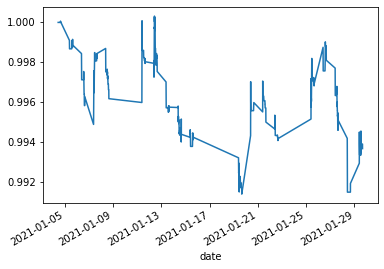

In [219]:
(1 + strategy_df['Return']).cumprod().plot()

這個策略的假設:  
- 一定可以買或賣在當天的 close price  
- Time frame 是 intraday，但此策略可以持有到隔天。 (即不考慮 overnight risk)  
- 沒有考慮到其他手續費   
